In [1]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
Notebook Last Run Initiated: 2023-01-20 15:45:46.584713


## Setup

In [2]:
import numpy as np
np.random.seed(seed=46)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import tensorflow_addons as tfa
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from PIL import Image
from PIL import ImageEnhance

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.9.0


In [5]:
def create_folds(data, num_splits):
    data["kfold"] = -1

    kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data['class'].values)):
        data.loc[v_, 'kfold'] = f

    return data

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
        
    def __init__(self, df_X, arr_Y, batch_size=32,shuffle=False,image_size=128):
        self.batch_size = batch_size
        self.df_X = df_X
        self.arr_Y = arr_Y
        self.indices = self.df_X.index.tolist()
        self.shuffle = shuffle
        self.image_size = image_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y
    
    def n(self):
        return len(self.indices)
    
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
               
        for i, id in enumerate(batch):
                       
            # Data
            file = self.df_X.iloc[self.indices[id],0]
            img = load_img(file,color_mode='rgb', target_size=(self.image_size,self.image_size),interpolation='nearest')
            
            img = img_to_array(img).astype(np.float32)
                        
            X.append(img/255.)
                        
            y.append(self.arr_Y[self.indices[id]])
            
        return np.array(X), np.array(y).reshape(self.batch_size,1)

## Prepare the data

In [7]:
data = pd.read_csv('train_P00.csv')

In [8]:
print(data.shape)

(7616, 2)


In [9]:
num_classes = 4
input_shape = (128, 128, 3)

In [10]:
class_map = {'bolt':0, 'locatingpin':1, 'nut':2, 'washer':3}
data['class'] = data['class'].map(class_map)

In [11]:
n_folds = 5
data = create_folds(data, num_splits=n_folds)

In [12]:
fold_num = 0

trn_idx = data[data['kfold'] != fold_num].index
val_idx = data[data['kfold'] == fold_num].index    
        
X_train = pd.DataFrame(data.iloc[trn_idx,0].reset_index(drop=True).copy(),columns=['file_path'])
y_train = data.iloc[trn_idx,1].reset_index(drop=True).copy() 
        
X_test  = pd.DataFrame(data.iloc[val_idx,0].reset_index(drop=True).copy(),columns=['file_path'])
y_test  = data.iloc[val_idx,1].reset_index(drop=True).copy() 

## Configure the hyperparameters

In [13]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 128  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 24
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Implement multilayer perceptron (MLP)

In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement patch creation as a layer

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


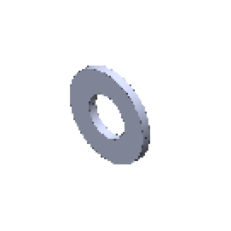

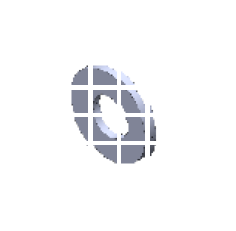

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

image = img_to_array(load_img(X_train.loc[np.random.choice(range(X_train.shape[0])),'file_path'],
                     color_mode='rgb', 
                     target_size=(image_size,image_size),
                     interpolation='nearest'))

plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [18]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the model

In [19]:

def run_experiment(model):
    
    tf.random.set_seed(46)
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)
    
    checkpoint_filepath = "tmp/checkpoint_P00.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode='min')

    train_generator = DataGenerator(df_X=X_train, arr_Y=y_train, batch_size=batch_size, shuffle=True,image_size=image_size)
    test_generator = DataGenerator(df_X=X_test, arr_Y=y_test, batch_size=batch_size,image_size=image_size)
    
    STEP_SIZE_TRAIN = train_generator.n()//train_generator.batch_size
    STEP_SIZE_VALID = test_generator.n()//test_generator.batch_size
    
    history = model.fit(x=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=test_generator,
                        validation_steps=STEP_SIZE_VALID, 
                        batch_size=batch_size,
                        epochs=num_epochs,
                        callbacks=[checkpoint_callback,early_stopping])

    model.load_weights(checkpoint_filepath)
    loss = model.evaluate(x=test_generator,steps=STEP_SIZE_VALID)
    print(f"loss : {loss}")

    return history


In [20]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
190/190 [==============================] - 49s 153ms/step - loss: 2.0622 - val_loss: 1.3929
Epoch 2/100
190/190 [==============================] - 26s 135ms/step - loss: 1.4337 - val_loss: 1.3876
Epoch 3/100
190/190 [==============================] - 28s 145ms/step - loss: 1.4166 - val_loss: 1.3885
Epoch 4/100
190/190 [==============================] - 28s 147ms/step - loss: 1.3968 - val_loss: 1.3882
Epoch 5/100
190/190 [==============================] - 27s 144ms/step - loss: 1.3895 - val_loss: 1.3867
Epoch 6/100
190/190 [==============================] - 28s 148ms/step - loss: 1.3920 - val_loss: 1.3861
Epoch 7/100
190/190 [==============================] - 28s 145ms/step - loss: 1.3892 - val_loss: 1.3867
Epoch 8/100
190/190 [==============================] - 27s 142ms/step - loss: 1.3914 - val_loss: 1.3859
Epoch 9/100
190/190 [==============================] - 29s 155ms/step - loss: 1.3932 - val_loss: 1.3856
Epoch 10/100
190/190 [==============================] - 28s 145m

In [21]:
test_generator = DataGenerator(df_X=X_test, arr_Y=y_test, batch_size=1)
STEP_SIZE_VALID = test_generator.n()

predict_result = vit_classifier.predict(test_generator,steps=STEP_SIZE_VALID)
prediction = predict_result

1524/1524 [==============================] - 72s 46ms/step


In [22]:
layer_softmax = tf.keras.layers.Softmax()
results = pd.DataFrame()
results = X_test
prediction_result = layer_softmax(prediction).numpy()
results['prediction'] = tf.math.argmax(prediction_result,axis=1)

In [23]:
results.to_csv('results_P00.csv',index=False)

In [24]:
# Validate with different dataset

In [25]:
validation = pd.read_csv('train.csv')
#validation = validation.loc[validation.bolts == 5]
#validation.reset_index(inplace=True,drop=True)

In [26]:
test_generator = DataGenerator(df_X=validation, arr_Y=validation.bolts.values, batch_size=1)
STEP_SIZE_VALID = test_generator.n()

In [27]:
predict_validation = vit_classifier.predict(test_generator,steps=STEP_SIZE_VALID)
validation_result = layer_softmax(predict_validation).numpy()

702/702 [==============================] - 27s 39ms/step


In [28]:
validation_data = pd.DataFrame()
validation_data = validation
validation_data['prediction'] = tf.math.argmax(validation_result,axis=1)
validation_data.to_csv('validation.csv',index=False)

In [29]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 64, 64)       53312       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 64, 64)      128         ['patch_encoder[0][0]']      

 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 64, 64)       0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 64, 64)      128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 64, 128)      8320        ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6

 dropout_13 (Dropout)           (None, 64, 64)       0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 64, 64)       0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 64, 64)      128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 64, 64)      99520       ['layer_normalization_14[0][0]', 
 eadAttention)                                                    'layer_normalization_14[0][0]'] 
          

 layer_normalization_21 (LayerN  (None, 64, 64)      128         ['add_20[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_21 (Dense)               (None, 64, 128)      8320        ['layer_normalization_21[0][0]'] 
                                                                                                  
 dropout_20 (Dropout)           (None, 64, 128)      0           ['dense_21[0][0]']               
                                                                                                  
 dense_22 (Dense)               (None, 64, 64)       8256        ['dropout_20[0][0]']             
                                                                                                  
 dropout_21 (Dropout)           (None, 64, 64)       0           ['dense_22[0][0]']               
          

 layer_normalization_28 (LayerN  (None, 64, 64)      128         ['add_27[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_14 (Multi  (None, 64, 64)      99520       ['layer_normalization_28[0][0]', 
 HeadAttention)                                                   'layer_normalization_28[0][0]'] 
                                                                                                  
 add_28 (Add)                   (None, 64, 64)       0           ['multi_head_attention_14[0][0]',
                                                                  'add_27[0][0]']                 
                                                                                                  
 layer_normalization_29 (LayerN  (None, 64, 64)      128         ['add_28[0][0]']                 
 ormalizat

 dropout_34 (Dropout)           (None, 64, 128)      0           ['dense_35[0][0]']               
                                                                                                  
 dense_36 (Dense)               (None, 64, 64)       8256        ['dropout_34[0][0]']             
                                                                                                  
 dropout_35 (Dropout)           (None, 64, 64)       0           ['dense_36[0][0]']               
                                                                                                  
 add_35 (Add)                   (None, 64, 64)       0           ['dropout_35[0][0]',             
                                                                  'add_34[0][0]']                 
                                                                                                  
 layer_normalization_36 (LayerN  (None, 64, 64)      128         ['add_35[0][0]']                 
 ormalizat

                                                                                                  
 add_42 (Add)                   (None, 64, 64)       0           ['multi_head_attention_21[0][0]',
                                                                  'add_41[0][0]']                 
                                                                                                  
 layer_normalization_43 (LayerN  (None, 64, 64)      128         ['add_42[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_43 (Dense)               (None, 64, 128)      8320        ['layer_normalization_43[0][0]'] 
                                                                                                  
 dropout_42 (Dropout)           (None, 64, 128)      0           ['dense_43[0][0]']               
          

__________________________________________________________________________________________________


In [30]:
from keras.utils.vis_utils import plot_model
import pydot

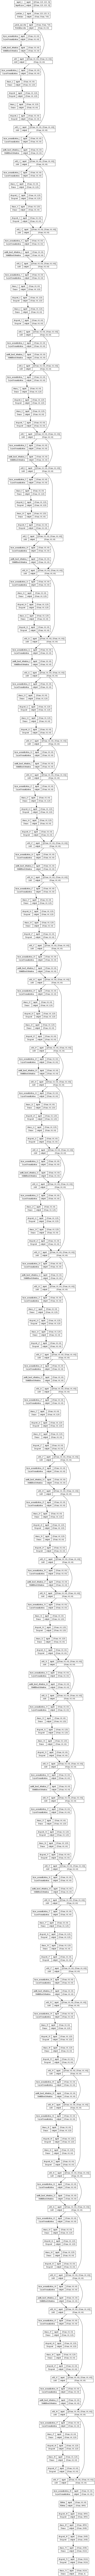

In [31]:
plot_model(vit_classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)